In [98]:
%matplotlib inline
import torch
import torchvision
from torchvision import transforms
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt

In [99]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [100]:
val_transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(0.49, 0.248),

])

val_dataset = torchvision.datasets.DatasetFolder("Processed/val/", loader=load_file, extensions="npy", transform=val_transforms)

In [101]:
temp_model = torchvision.models.resnet18()
temp_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [102]:
list(temp_model.children())[:-2]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [103]:
torch.nn.Sequential(*list(temp_model.children())[:-2])

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [104]:
class PneumoniaModel(pl.LightningModule):

    def __init__(self):

        super().__init__()
        
        self.model = torchvision.models.resnet18()
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)
        
        self.feature_map = torch.nn.Sequential(*list(self.model.children())[:-2])  

    def forward(self, data):
        
        feature_map = self.feature_map(data)
        avg_pool_output = torch.nn.functional.adaptive_avg_pool2d(input=feature_map, output_size=(1, 1))
        print(avg_pool_output.shape)
        avg_pool_output_flattened = torch.flatten(avg_pool_output)
        print(avg_pool_output_flattened.shape)

        pred = self.model.fc(avg_pool_output_flattened)
        return pred, feature_map
    

In [105]:
model = PneumoniaModel.load_from_checkpoint("./logs/lightning_logs/version_4/checkpoints/epoch=30-step=11625.ckpt", strict=False)
model.eval();

e:\Muffinwares pc\Pneumonia\.venv\Lib\site-packages\pytorch_lightning\core\saving.py:191: Found keys that are in the model state dict but not in the checkpoint: ['feature_map.0.weight', 'feature_map.1.weight', 'feature_map.1.bias', 'feature_map.1.running_mean', 'feature_map.1.running_var', 'feature_map.4.0.conv1.weight', 'feature_map.4.0.bn1.weight', 'feature_map.4.0.bn1.bias', 'feature_map.4.0.bn1.running_mean', 'feature_map.4.0.bn1.running_var', 'feature_map.4.0.conv2.weight', 'feature_map.4.0.bn2.weight', 'feature_map.4.0.bn2.bias', 'feature_map.4.0.bn2.running_mean', 'feature_map.4.0.bn2.running_var', 'feature_map.4.1.conv1.weight', 'feature_map.4.1.bn1.weight', 'feature_map.4.1.bn1.bias', 'feature_map.4.1.bn1.running_mean', 'feature_map.4.1.bn1.running_var', 'feature_map.4.1.conv2.weight', 'feature_map.4.1.bn2.weight', 'feature_map.4.1.bn2.bias', 'feature_map.4.1.bn2.running_mean', 'feature_map.4.1.bn2.running_var', 'feature_map.5.0.conv1.weight', 'feature_map.5.0.bn1.weight', 'fe

In [106]:
def cam(model, img):
     
     with torch.no_grad():
        
        device = next(model.parameters()).device
        img = img.to(device)

        pred, features = model(img.unsqueeze(0))
        features = features.reshape((512, 49))

        weight = list(model.model.fc.parameters())[0][0].detach()

        cam = torch.matmul(weight, features).reshape(7, 7)
        return cam.cpu(), torch.sigmoid(pred)


In [130]:
def visualize(img, cam, pred): 

    img_np = img.cpu().numpy().squeeze()  
    cam_np = cam.cpu().numpy()  

    cam_tensor = torch.from_numpy(cam_np).unsqueeze(0).unsqueeze(0)  
    cam_resized = transforms.functional.resize(cam_tensor, img_np.shape[-2:])[0][0].numpy()
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img_np, cmap="bone")
    axes[0].set_title("Original Image")

    axes[1].imshow(img_np, cmap="bone")
    axes[1].imshow(cam_resized, alpha=0.5, cmap="jet")
    axes[1].set_title(f"Prediction: {'Pneumonia' if pred.item() > 0.3 else 'Normal'} (prob: {pred.item():.2f})")
    plt.show()
    
    plt.show()

In [131]:
img = val_dataset[-7][0].to(model.device)
activation_map, pred = cam(model, img)

torch.Size([1, 512, 1, 1])
torch.Size([512])


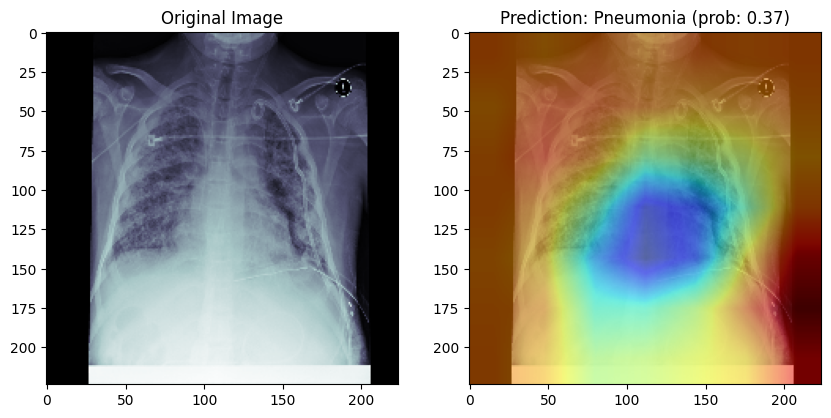

In [132]:
visualize(img, activation_map, pred)

In [135]:
img = val_dataset[-6][0].to(model.device)
activation_map, pred = cam(model, img)

torch.Size([1, 512, 1, 1])
torch.Size([512])


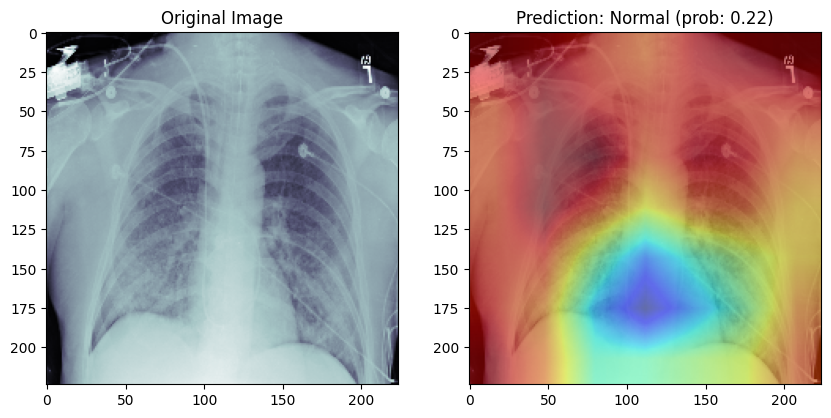

In [136]:
visualize(img, activation_map, pred)